In [1]:
import torch
import torch.nn as nn
import torchvision

%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

import time
import os
os.environ['KMP_DUPLICATE_?LIB_OK']='True'

from dataset import *
from transforms import *
from criteria import *
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

In [2]:
# # BSDS 500

# # NOTE: remember to adjust PadTo2Power's k value according to gamma-net depth
# # NOTE: data stays in CPU until right before forward pass (i.e. no need for memory pinning, etc)

# x_transform = torchvision.transforms.Compose([CenterCrop((256,256)),
#                                               ToTensor(make_channel_first=True, div=True),
#                                               PadTo2Power(axes=(1,2), k=5, mode='constant'),
#                                               AssertWidthMajor()])
# y_transform = torchvision.transforms.Compose([CenterCrop((256,256)),
#                                               ToTensor(make_channel_first=False, float_out=False),
#                                               PadTo2Power(axes=(0,1), k=5, mode='constant'),
#                                               AssertWidthMajor()])
# ds_train = SimpleDataset("bsds500/x_train.txt",
#                          "bsds500/y_c_train.txt",
#                          x_transform=x_transform, y_transform=y_transform)
# dl_train = DataLoader(ds_train, batch_size=4, shuffle=True, num_workers=0)

In [2]:
# ACDC

# NOTE: remember to adjust PadTo2Power's k value according to gamma-net depth
# NOTE: data stays in CPU until right before forward pass (i.e. no need for memory pinning, etc)

x_transform = torchvision.transforms.Compose([GaussianSmooth(3,1),
                                              CLAHE(clipLimit=2.0, tileGridSize=(8,8)),
                                              lambda x: (x-x.min()) / (x.max()-x.min()),
                                              PadOrCenterCrop(size=(224,224)),
                                              ToTensor(make_channel_first=True, div=False),
                                              ExpandDims(dim=0)])
y_transform = torchvision.transforms.Compose([PadOrCenterCrop(size=(224,224)),
                                              ToTensor(make_channel_first=False, float_out=False),
                                              SelectClass(3)])

# val_ratio = 0.2
# ds = SimpleDataset("ACDC_Dataset_p/training/x_arr.txt", "ACDC_Dataset_p/training/y_arr.txt",
#                    x_transform=x_transform, y_transform=y_transform, use_cache=True)
# ds_train, ds_val = random_split(ds, [len(ds) - int(len(ds)*val_ratio), int(len(ds)*val_ratio)])

data_dir = "ACDC_split/training_1-9/"
ds_train = SimpleDataset(data_dir + "x_train.txt", data_dir + "y_train.txt",
                         x_transform=x_transform, y_transform=y_transform, use_cache=True)
ds_val = SimpleDataset(data_dir + "x_val.txt", data_dir + "y_val.txt",
                         x_transform=x_transform, y_transform=y_transform, use_cache=True)

dl_train = DataLoader(ds_train, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=16, shuffle=True, num_workers=0, pin_memory=True)

# Gamma-Net

In [3]:
from gammanet import GammaNet

gammanet_config = {
    'in_channels': 1,
    'return_sequences': False,
    'num_filters': [24, 28, 32, 48, 64],
    'conv_kernel_size': [3, 3, 3, 3, 3],
    'conv_blocksize': [1, 1, 1, 1, 1],
    'conv_normtype': 'instancenorm',
    'conv_dropout_p': 0.2,  # 0.2
    'conv_residual': False,
    'fgru_hidden_size': [24, 28, 32, 48, 64],
    'fgru_kernel_size': [9,  7,  5,  3,  1,  1,  1,  1,  1],
    'fgru_timesteps': 4,
    'fgru_normtype': 'instancenorm',
    'fgru_channel_sym': True,
#     'fgru_attention_args': None,
    'fgru_attention_args': {
                "type": "gala",
                "filters": 5,
                "layers": 1
            },
    'upsample_mode': 'bilinear',
    'upsample_all2all': True,
}

model = nn.Sequential(
#     nn.Conv2d(1, 24, 3, padding=1), # Change the number of input channels! 
#     nn.Conv2d(24, 24, 3, padding=1),
    GammaNet(gammanet_config),
    nn.ReLU(), 
    nn.BatchNorm2d(24, eps=1e-3),
    nn.Conv2d(24, 2, 5, padding=2),  # Change the expected number of output classes! 
    nn.ReLU(),
    nn.BatchNorm2d(2, eps=1e-3),
    nn.Conv2d(2, 2, 1, padding=0)
)

if torch.cuda.is_available():
    model = model.cuda().float()
else:
    model = model.double()

In [4]:
sum(p.numel() for p in model.parameters())

481403

In [5]:
load_model = False
model_file = "models_gn_8_1-9/model_e200.pkl"
if load_model:
    if torch.cuda.is_available():
        model.load_state_dict(torch.load(model_file))
    else:
        model.load_state_dict(torch.load(model_file, map_location=torch.device('cpu')))

In [6]:
model = nn.DataParallel(model)

## Training model

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
criterion = criterion.cuda() if torch.cuda.is_available() else criterion
optimizer = optim.Adam(model.parameters(), lr=1e-3)

<IPython.core.display.Javascript object>


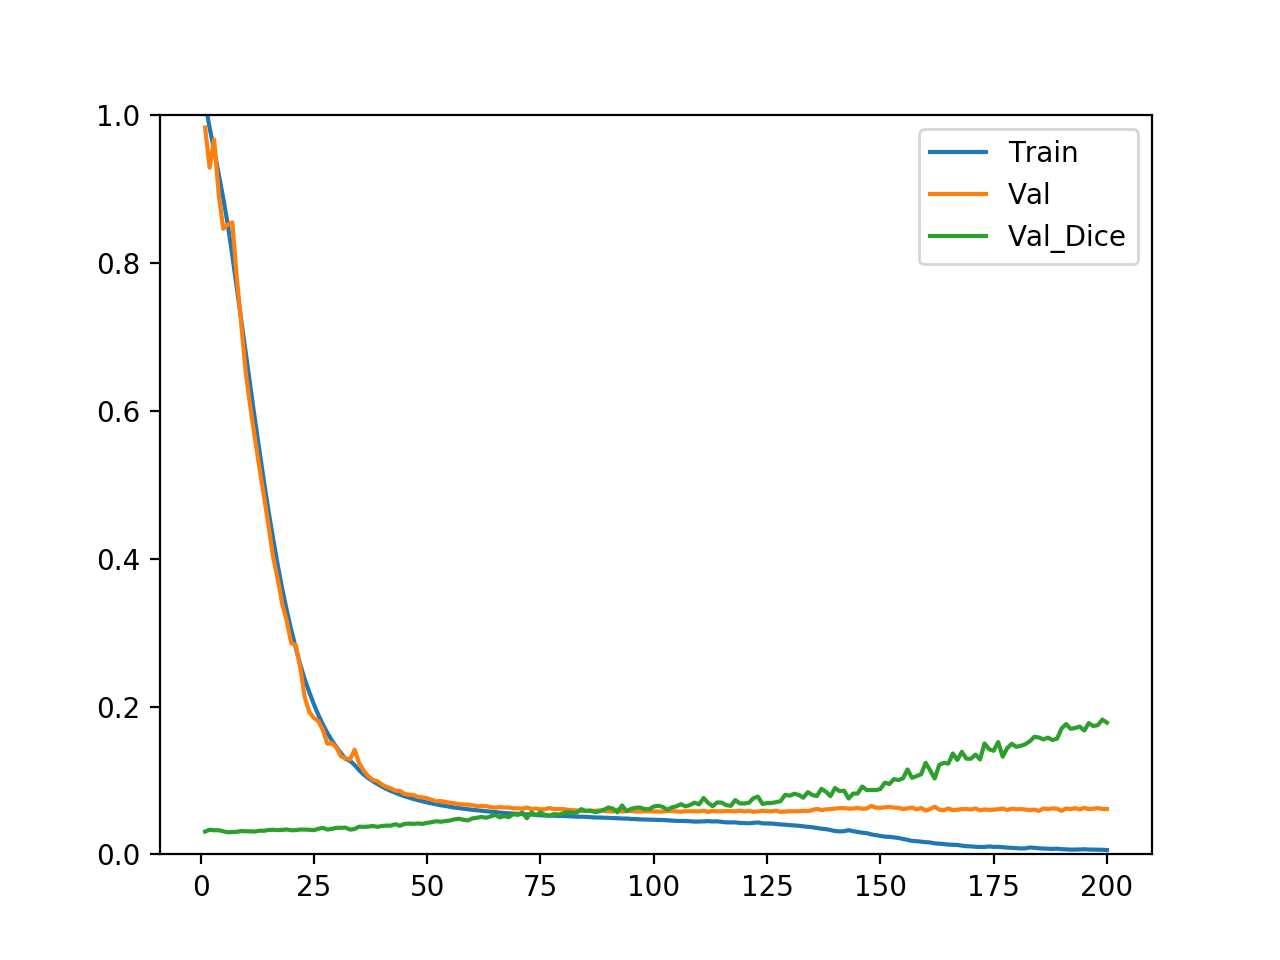

In [8]:
fig, ax = plt.subplots(1, 1)
ax.set_ylim(0,1)
hl_train, = ax.plot([], [])
hl_val, = ax.plot([], [])
hl_val_dice, = ax.plot([], [])
fig.canvas.draw()

In [9]:
from datetime import datetime, timedelta
start_time = datetime.now()

save_model = True
save_period = 10
save_root = "exp_gn_7/"
model_file_template = save_root + "model_e{}.pkl"

save_loss = True
loss_file_path = save_root + "loss.pkl"
loss_png_path = save_root + "loss.png"
train_loss = []
val_loss = []
val_dice = []

epochs = 200
for epoch in range(epochs):  # loop over the dataset multiple times

    model.train()
    train_loss_epoch = []
    for i, data in enumerate(dl_train):
        inputs = data[0].cuda().float() if torch.cuda.is_available() else data[0].double()
        labels = data[1].cuda().long() if torch.cuda.is_available() else data[1].long()

        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss_epoch += [loss.item()]

        # print statistics
        progress = (i+1 + epoch*len(dl_train)) / (epochs*len(dl_train))
        time_elapsed = datetime.now() - start_time
        time_to_completion = time_elapsed / progress - time_elapsed
        print("Epoch: {}, Train, Batch {}/{}, ETA: ".format(epoch+1, i+1, len(dl_train)) + 
              str(time_to_completion), end='\r')
                
    model.eval()
    val_loss_epoch = []
    val_dice_epoch = []
    for i, data in enumerate(dl_val):
        inputs = data[0].cuda().float() if torch.cuda.is_available() else data[0].double()
        labels = data[1].cuda().long() if torch.cuda.is_available() else data[1].long()
        
        with torch.no_grad():
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            dice = dice_coeff(torch.sigmoid(outputs[:,1]), labels)
#             dice = dice_coeff_mc(torch.sigmoid(outputs), labels)
        val_loss_epoch += [loss.item()]
        val_dice_epoch += [dice.item()]
        
        print("Epoch: {}, Val, Batch {}/{}".format(epoch+1, i+1, len(dl_val))+' '*40, end='\r')

    train_loss += [train_loss_epoch]
    val_loss += [val_loss_epoch]
    val_dice += [val_dice_epoch]
    
    # update loss graph
    hl_train.set_xdata(np.append(hl_train.get_xdata(), epoch+1))
    hl_train.set_ydata(np.append(hl_train.get_ydata(), np.mean(train_loss_epoch)))
    hl_val.set_xdata(np.append(hl_val.get_xdata(), epoch+1))
    hl_val.set_ydata(np.append(hl_val.get_ydata(), np.mean(val_loss_epoch)))
    hl_val_dice.set_xdata(np.append(hl_val_dice.get_xdata(), epoch+1))
    hl_val_dice.set_ydata(np.append(hl_val_dice.get_ydata(), np.mean(val_dice_epoch)))
    ax.legend(['Train','Val','Val_Dice']); ax.relim(); ax.autoscale(axis='x'); fig.canvas.draw()
        
    if save_model and (epoch+1) % save_period == 0:
        if not os.path.exists(save_root):
            os.makedirs(save_root)
        if isinstance(model, nn.DataParallel):
            torch.save(model.module.state_dict(), model_file_template.format(epoch+1))
        else:
            torch.save(model.state_dict(), model_file_template.format(epoch+1))

if save_loss:
    pickle.dump((train_loss, val_loss, val_dice), open(loss_file_path, 'wb'))
    plt.savefig(loss_png_path)

print('\nFinished Training')

Epoch: 200, Val, Batch 110/110                                        
Finished Training


In [ ]:
if save_loss:
    pickle.dump((train_loss, val_loss, val_dice), open(loss_file_path, 'wb'))
    plt.savefig(loss_png_path)

# Tests

In [ ]:
# BSDS500 test set

x_transform = torchvision.transforms.Compose([Resize(size=(150,150)),
                                              ToTensor(make_channel_first=True, div=False),
                                              PadTo2Power(axes=(1,2), k=5, mode='constant'),
                                              AssertWidthMajor()])
ds_test = SimpleDataset("bsds500/x_test.txt", x_transform=x_transform)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False, num_workers=0)

In [ ]:
# ACDC test set

x_transform = torchvision.transforms.Compose([PadOrCenterCrop(size=(224,224)),
                                              ToTensor(make_channel_first=True, div=True),
                                              ExpandDims(dim=0)])
ds_test = SimpleDataset("ACDC_Dataset_p/testing/x_arr.txt", x_transform=x_transform)
dl_test = DataLoader(ds_test, batch_size=4, shuffle=True, num_workers=0)

In [5]:
# load from val data

x,y = next(iter(dl_val))
x = x.float() if torch.cuda.is_available() else x.double()
print(x.shape, y.shape)
print(x.max(),x.min(),y.max(),y.min())

torch.Size([8, 1, 224, 224]) torch.Size([8, 224, 224])
tensor(1.) tensor(0.) tensor(1, dtype=torch.int32) tensor(0, dtype=torch.int32)


In [ ]:
# load from test data

x = next(iter(dl_test))
x = x.float() if torch.cuda.is_available() else x.double()
print(x.shape)
print(x.max(),x.min())
if "y" in dir():
    del(y)

## Result visualizations

In [11]:
# run test data through model

model.eval()
with torch.no_grad():
    res = model(x)

In [ ]:
# visualize ACDC results

for i in range(x.shape[0]):
    print(i)
    plt.figure(figsize=(15,10))
    plt.subplot(2,3,1)
    plt.imshow(x[i].numpy()[0], cmap='gray')
    if "y" in dir():
        plt.subplot(2,3,2)
        plt.imshow(y[i])
    for j in range(4):
        plt.subplot(2,3,3+j)
        plt.imshow(res.cpu().detach().numpy()[i,j])
    plt.show()

In [ ]:
dice_coeff_mc(res.cpu(),y)

## Result visualization per timestep

In [ ]:
# request gammanet to return sequence

m = model.module
m[2].config['return_sequences'] = True

In [ ]:
# get returned sequences from gammanet 

out = m[0](x)
out = m[1](out)
out = m[2](out)

In [ ]:
# visualize  per-timestep outputs

idx = 3
label = 1

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(x[idx].cpu().detach().numpy()[0], cmap='gray')
if "y" in dir():
    plt.subplot(1,2,2)
    plt.imshow(y[idx])
plt.show()

plt.figure(figsize=(20,20))
for i, o in enumerate(out[1]):
    o = m[3](o)
    plt.subplot(len(out[1])//4+1, 4, i+1)
    plt.imshow(o[idx,label].cpu().detach().numpy())
plt.show()

In [ ]:
del(out)

## fGRU kernel visualization

In [ ]:
# inhibition kernels in first down block fGRU
k = model.module.state_dict()['2.fgru_down.0.params.w_inh']
for i in range(k.shape[0]):
    print(i)
    plt.figure(figsize=(15,10))
    for j in range(k.shape[1]):
        plt.subplot(4,6,j+1)
        plt.imshow(k.cpu().detach().numpy()[i,j])
    plt.show()

In [ ]:
# excitation kernels in first down block fGRU
k = model.module.state_dict()['2.fgru_down.0.params.w_exc']
for i in range(k.shape[0]):
    print(i)
    plt.figure(figsize=(15,10))
    for j in range(k.shape[1]):
        plt.subplot(4,6,j+1)
        plt.imshow(k.cpu().detach().numpy()[i,j])
    plt.show()

In [ ]:
k = model.module.state_dict()['2.fgru_down.1.params.w_inh']
plt.figure(figsize=(15,10))
for i in range(k.shape[0]):
    plt.subplot(4,7,i+1)
    plt.imshow(k.cpu().detach().numpy()[0,i])
plt.show()

In [ ]:
k = model.module.state_dict()['2.fgru_down.1.params.w_exc']
plt.figure(figsize=(15,10))
for i in range(k.shape[0]):
    plt.subplot(4,7,i+1)
    plt.imshow(k.cpu().detach().numpy()[0,i])
plt.show()